# COVID-19 diagnosis using CT images

## Construct Resnet-18 CNN and Train from scratch
Author: Annika Murray 

Date: 12/28/2023

In [1]:
import data_loader
from data_loader import get_dataloader
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as nnF
from torch.utils.data import DataLoader as torch_dataloader
from torch.utils.data import Dataset as torch_dataset
import torch.optim as optim
import torchvision.models as models
from torchvision.models import ResNet18_Weights
from IPython import display
from pytorch_grad_cam import (GradCAM, EigenCAM)
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
import skimage

In [2]:
data_train, loader_train, loader_val, loader_test = get_dataloader()

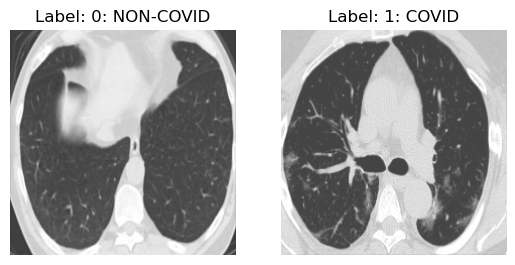

In [3]:
# Show two images side by side
%matplotlib inline

image1, label1 = data_train[0]
image2, label2 = data_train[1000]

plt.subplot(1, 2, 1)
plt.imshow(image1.permute(1, 2, 0).numpy())
plt.title(f"Label: {label1.item()}: NON-COVID")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(image2.permute(1, 2, 0).numpy())
plt.title(f"Label: {label2.item()}: COVID")
plt.axis('off')

plt.show()

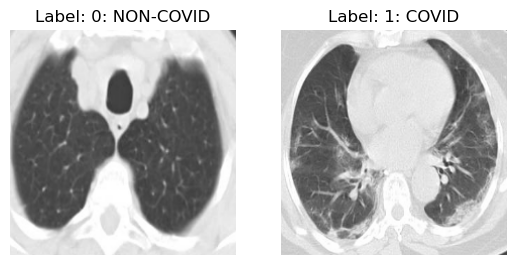

In [4]:
# Show two more images side by side
image1b, label1b = data_train[1]
image2b, label2b = data_train[1001]

plt.subplot(1, 2, 1)
plt.imshow(image1b.permute(1, 2, 0).numpy())
plt.title(f"Label: {label1b.item()}: NON-COVID")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(image2b.permute(1, 2, 0).numpy())
plt.title(f"Label: {label2b.item()}: COVID")
plt.axis('off')

plt.show()

Later, we will use these two images to display insights into which regions of an input image are crucial for the model's decision. This helps researchers and practitioners understand where the model is focusing its attention.

### 1) Construct a CNN by modifying Resnet-18 or Resnet-50 for binary classification

In [5]:
class ModResNet18(nn.Module):
    def __init__(self):
        super().__init__()
        resnet18 = models.resnet18(pretrained=False)
        self.features = nn.Sequential(*list(resnet18.children())[:-1])
        self.fc1 = nn.Linear(512, 2)
        
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        return x

In [6]:
model=ModResNet18()

/Users/annikamurray/opt/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/annikamurray/opt/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


New ResNet18 Model strcuture for binary classification: Covid or Non-Covid

### 2) Train the CNN from scratch

In [7]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)
print("Model device:", next(model.parameters()).device)

Model device: cpu


In [8]:
#Loss function optimizer
optimizer = optim.Adamax(model.parameters(), lr=0.001, weight_decay=1e-4)

In [9]:
def cal_accuracy(confusion):
    M=confusion.copy().astype('float32')
    acc = M.diagonal().sum()/M.sum()         
    return acc

In [10]:
#Variables to keep track of stuff
import time

epochs=5

train_loss_list=[]
train_acc_list=[]
val_acc_list=[]
test_acc_list=[]

#### Training Function

In [11]:
def train(model, device, optimizer, dataloader, epoch):    
    model.train()#set model to training mode
    
    train_correct=0
    train_loss=0
    
    for batch_idx, (X, Y) in enumerate(dataloader):
        X, Y = X.to(device), Y.to(device)
        
        #Predicting / Updating parameters
        optimizer.zero_grad()#clear grad of each parameters
        Z = model(X) # Forward pass; Get predicted values from model
        loss = nnF.cross_entropy(Z, Y) # Cross-entropy loss; compare predictions to actual
        loss.backward()#backward pass
        optimizer.step()#update parameters
        
        train_loss+=loss.item() #Getting train loss
        Yp = Z.data.max(dim=1)[1]  # Get the index of the max 
        train_correct += torch.sum(Yp==Y).item() #Correct predictions
        
    train_loss/=len(dataloader)
    train_correct/=len(dataloader.dataset) 

    print(f'Epoch: [{epoch}] Loss: {loss.item()} Training Acc: {train_correct}')
        
    return train_loss, train_correct

#### Testing Function

In [12]:
def test(model, device, dataloader):
    model.eval()#set model to evaluation mode
    
    confusion=np.zeros((2,2))

    with torch.no_grad(): # tell Pytorch not to build graph in the with section
        for batch_idx, (X, Y) in enumerate(dataloader):
            X, Y = X.to(device), Y.to(device)
            
            #Predicting / Updating parameters
            Z = model(X)# Forward pass; Get predicted values from model
            Yp = Z.data.max(dim=1)[1]  # Get the index of the max
            
            #Confusion Matrix
            for i in range(0, 2):
                for j in range(0, 2):
                    confusion[i,j]+=torch.sum((Y==i)&(Yp==j)).item()
    
    #Calculates the accuracy
    acc = cal_accuracy(confusion)
            
    return acc, confusion

In [13]:
print("Training attempt (by scratch)...")
print("Started at 0.00")
start_time=time.time()
for epoch in range(epochs):
    #-------- training --------------------------------
    loss_train, acc_train =train(model, device, optimizer, loader_train, epoch)    
    train_loss_list.append(loss_train)
    train_acc_list.append(acc_train)
    #-------- validation --------------------------------
    acc_val, other = test(model, device, loader_val)
    val_acc_list.append(acc_val)
    print(f'Validation Accuracy: {acc_val}')
    #-------- testing --------------------------------
    acc_test, confused = test(model, device, loader_test)
    test_acc_list.append(acc_test)
    print(f'Testing Accuracy: {acc_test}')
    
current_time=time.time()
total_time= current_time-start_time
print(f"Training time: {total_time/60} minutes")

Training attempt (by scratch)...
Started at 0.00
Epoch: [0] Loss: 0.05659179016947746 Training Acc: 0.8160237388724035
Validation Accuracy: 0.7666666507720947
Testing Accuracy: 0.8199999928474426
Epoch: [1] Loss: 1.3895171880722046 Training Acc: 0.890702274975272
Validation Accuracy: 0.550000011920929
Testing Accuracy: 0.5550000071525574
Epoch: [2] Loss: 0.031172851100564003 Training Acc: 0.9411473788328387
Validation Accuracy: 0.800000011920929
Testing Accuracy: 0.8125
Epoch: [3] Loss: 0.06430239230394363 Training Acc: 0.9574678536102869
Validation Accuracy: 0.8166666626930237
Testing Accuracy: 0.824999988079071
Epoch: [4] Loss: 0.009421643801033497 Training Acc: 0.9658753709198813
Validation Accuracy: 0.800000011920929
Testing Accuracy: 0.762499988079071
Training time: 16.685190800825755 minutes


In [14]:
confused #confusion matrix

array([[199.,   1.],
       [ 94., 106.]])

### 4) Visualize the two models using two CAM methods

In [20]:
class ClassifierOutputTarget:
    def __init__(self, category):
        self.category = category

    def __call__(self, model_output):
        if len(model_output.shape) == 1:
            return model_output[self.category]
        return model_output[:, self.category]

In [21]:
image1.shape
image1 = image1.permute(1, 2, 0).cpu().numpy()
image2.shape
image2 = image2.permute(1, 2, 0).cpu().numpy()
image1b.shape
image1b = image1b.permute(1, 2, 0).cpu().numpy()
image2b.shape
image2b = image2b.permute(1, 2, 0).cpu().numpy()
target_layers = [model.features[7][-1]]

## Model 1 : Trained from scratch

### GradCAM

Text(0.5, 1.0, 'GradCAM')

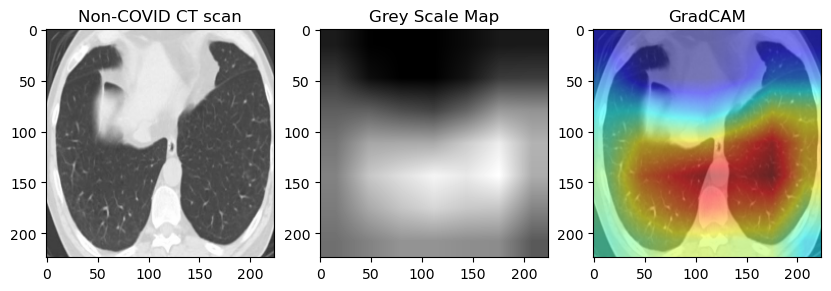

In [22]:
image_input=torch.tensor(image1).permute(2,0,1)
image_input=image_input.reshape(1,3,224,224)
image_input.shape
targets = [ClassifierOutputTarget(category=0)]
cam = GradCAM(model=model, target_layers=target_layers, use_cuda=False)
grayscale_cam = cam(input_tensor=image_input, targets=targets)
grayscale_cam=grayscale_cam[0]
cam_image = show_cam_on_image(image1, grayscale_cam, use_rgb=True)
fig, ax = plt.subplots(1,3, figsize=(10,10))
ax[0].imshow(image1)
ax[1].imshow(grayscale_cam, cmap='gray')
ax[2].imshow(cam_image)
ax[0].set_title("Non-COVID CT scan")
ax[1].set_title("Grey Scale Map")
ax[2].set_title("GradCAM")

Text(0.5, 1.0, 'GradCAM')

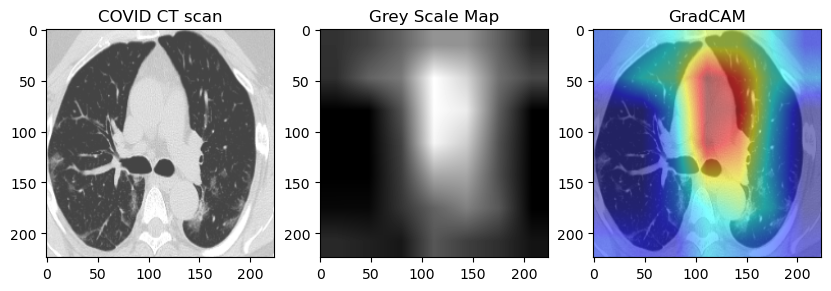

In [23]:
image_input=torch.tensor(image2).permute(2,0,1)
image_input=image_input.reshape(1,3,224,224)
image_input.shape
targets = [ClassifierOutputTarget(category=1)]
cam = GradCAM(model=model, target_layers=target_layers, use_cuda=False)
grayscale_cam = cam(input_tensor=image_input, targets=targets)
grayscale_cam=grayscale_cam[0]
cam_image = show_cam_on_image(image2, grayscale_cam, use_rgb=True)
fig, ax = plt.subplots(1,3, figsize=(10,10))
ax[0].imshow(image2)
ax[1].imshow(grayscale_cam, cmap='gray')
ax[2].imshow(cam_image)
ax[0].set_title("COVID CT scan")
ax[1].set_title("Grey Scale Map")
ax[2].set_title("GradCAM")

Text(0.5, 1.0, 'GradCAM')

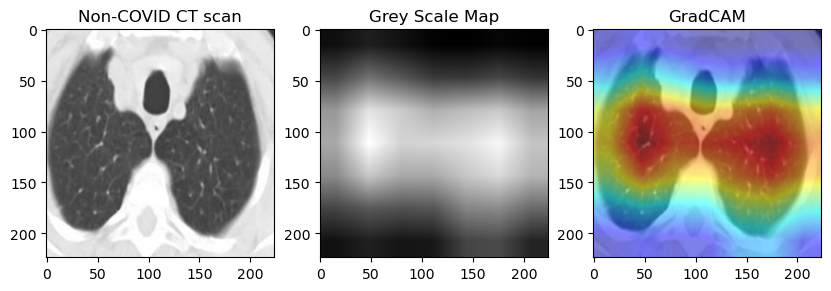

In [24]:
image_input=torch.tensor(image1b).permute(2,0,1)
image_input=image_input.reshape(1,3,224,224)
image_input.shape
targets = [ClassifierOutputTarget(category=0)]
cam = GradCAM(model=model, target_layers=target_layers, use_cuda=False)
grayscale_cam = cam(input_tensor=image_input, targets=targets)
grayscale_cam=grayscale_cam[0]
cam_image = show_cam_on_image(image1b, grayscale_cam, use_rgb=True)
fig, ax = plt.subplots(1,3, figsize=(10,10))
ax[0].imshow(image1b)
ax[1].imshow(grayscale_cam, cmap='gray')
ax[2].imshow(cam_image)
ax[0].set_title("Non-COVID CT scan")
ax[1].set_title("Grey Scale Map")
ax[2].set_title("GradCAM")

Text(0.5, 1.0, 'GradCAM')

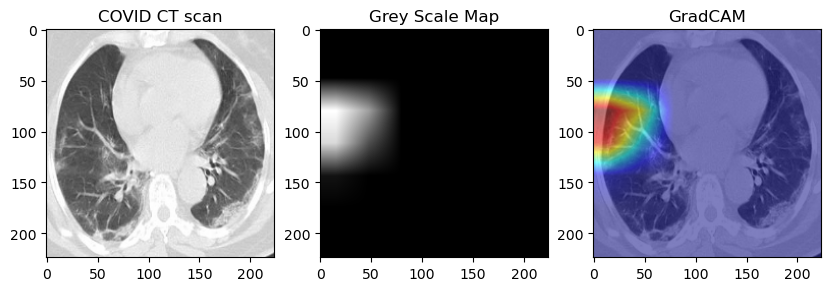

In [30]:
image_input=torch.tensor(image2b).permute(2,0,1)
image_input=image_input.reshape(1,3,224,224)
image_input.shape
targets = [ClassifierOutputTarget(category=0)]
cam = GradCAM(model=model, target_layers=target_layers, use_cuda=False)
grayscale_cam = cam(input_tensor=image_input, targets=targets)
grayscale_cam=grayscale_cam[0]
cam_image = show_cam_on_image(image2b, grayscale_cam, use_rgb=True)
fig, ax = plt.subplots(1,3, figsize=(10,10))
ax[0].imshow(image2b)
ax[1].imshow(grayscale_cam, cmap='gray')
ax[2].imshow(cam_image)
ax[0].set_title("COVID CT scan")
ax[1].set_title("Grey Scale Map")
ax[2].set_title("GradCAM")

Text(0.5, 1.0, 'EigenCAM')

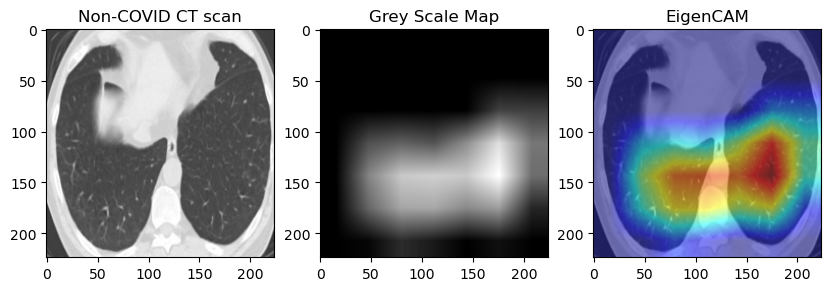

In [26]:
image_input=torch.tensor(image1).permute(2,0,1)
image_input=image_input.reshape(1,3,224,224)
image_input.shape
targets = [ClassifierOutputTarget(category=0)]
cam = EigenCAM(model=model, target_layers=target_layers, use_cuda=False)
grayscale_cam = cam(input_tensor=image_input, targets=targets)
grayscale_cam=grayscale_cam[0]
cam_image = show_cam_on_image(image1, grayscale_cam, use_rgb=True)
fig, ax = plt.subplots(1,3, figsize=(10,10))
ax[0].imshow(image1)
ax[1].imshow(grayscale_cam, cmap='gray')
ax[2].imshow(cam_image)
ax[0].set_title("Non-COVID CT scan")
ax[1].set_title("Grey Scalxe Map")
ax[2].set_title("EigenCAM")

Text(0.5, 1.0, 'EigenCAM')

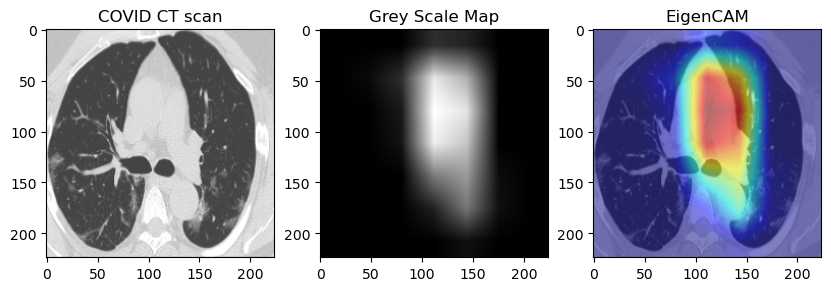

In [27]:
image_input=torch.tensor(image2).permute(2,0,1)
image_input=image_input.reshape(1,3,224,224)
image_input.shape
targets = [ClassifierOutputTarget(category=1)]
cam = EigenCAM(model=model, target_layers=target_layers, use_cuda=False)
grayscale_cam = cam(input_tensor=image_input, targets=targets)
grayscale_cam=grayscale_cam[0]
cam_image = show_cam_on_image(image2, grayscale_cam, use_rgb=True)
fig, ax = plt.subplots(1,3, figsize=(10,10))
ax[0].imshow(image2)
ax[1].imshow(grayscale_cam, cmap='gray')
ax[2].imshow(cam_image)
ax[0].set_title("COVID CT scan")
ax[1].set_title("Grey Scale Map")
ax[2].set_title("EigenCAM")

Text(0.5, 1.0, 'EigenCAM')

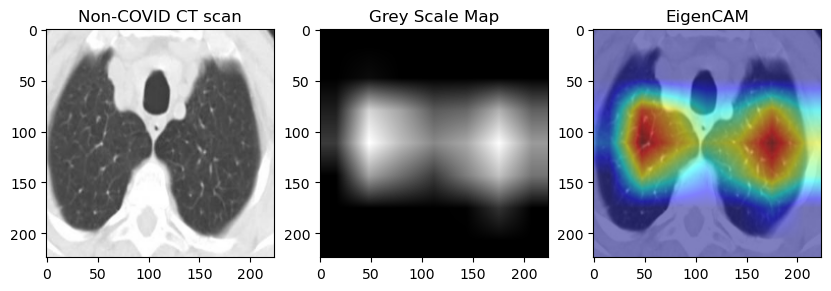

In [28]:
image_input=torch.tensor(image1b).permute(2,0,1)
image_input=image_input.reshape(1,3,224,224)
image_input.shape
targets = [ClassifierOutputTarget(category=0)]
cam = EigenCAM(model=model, target_layers=target_layers, use_cuda=False)
grayscale_cam = cam(input_tensor=image_input, targets=targets)
grayscale_cam=grayscale_cam[0]
cam_image = show_cam_on_image(image1b, grayscale_cam, use_rgb=True)
fig, ax = plt.subplots(1,3, figsize=(10,10))
ax[0].imshow(image1b)
ax[1].imshow(grayscale_cam, cmap='gray')
ax[2].imshow(cam_image)
ax[0].set_title("Non-COVID CT scan")
ax[1].set_title("Grey Scale Map")
ax[2].set_title("EigenCAM")

Text(0.5, 1.0, 'EigenCAM')

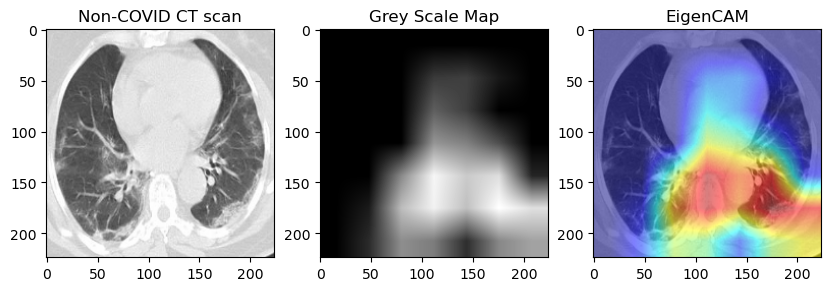

In [29]:
image_input=torch.tensor(image2b).permute(2,0,1)
image_input=image_input.reshape(1,3,224,224)
image_input.shape
targets = [ClassifierOutputTarget(category=0)]
cam = EigenCAM(model=model, target_layers=target_layers, use_cuda=False)
grayscale_cam = cam(input_tensor=image_input, targets=targets)
grayscale_cam=grayscale_cam[0]
cam_image = show_cam_on_image(image2b, grayscale_cam, use_rgb=True)
fig, ax = plt.subplots(1,3, figsize=(10,10))
ax[0].imshow(image2b)
ax[1].imshow(grayscale_cam, cmap='gray')
ax[2].imshow(cam_image)
ax[0].set_title("Non-COVID CT scan")
ax[1].set_title("Grey Scale Map")
ax[2].set_title("EigenCAM")